# MedTeller - Full Encoder-Decoder Training

Complete training pipeline for multimodal radiology report generation.

**Architecture:**
- **Encoder**: ViT (vision) + ClinicalBERT (text) → condition vector (1536-dim)
- **Decoder**: GPT-2 with conditioning projection

**Two-Stage Training:**
1. Text-only GPT-2 fine-tuning on radiology reports
2. Multimodal training with image+text conditioning



In [1]:
# Install required packages
!pip install -q transformers datasets accelerate rouge-score sacrebleu nltk matplotlib tensorboard tqdm


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# ============================================================================
# CONFIGURATION
# ============================================================================
# For A100 GPU - use full dataset
# Set to True for quick debugging, False for full training
USE_SAMPLE_TEXT = False

# Subsample settings (set to None for full data on A100)
MAX_TRAIN_MM = None  # Use all training samples
MAX_VAL_MM = None    # Use all validation samples

# Text-only decoder hyperparams (Stage 1)
TEXT_NUM_EPOCHS = 5
TEXT_LR = 5e-5
TEXT_TRAIN_BS = 8
TEXT_EVAL_BS = 8
TEXT_GRAD_ACCUM = 4
TEXT_MAX_LENGTH = 256

# Multimodal decoder hyperparams (Stage 2)
MM_NUM_EPOCHS = 10
MM_LR = 2e-5
MM_TRAIN_BS = 4
MM_EVAL_BS = 4
MM_GRAD_ACCUM = 4
MM_MAX_LENGTH = 256
COND_DIM = 1536  # 768 (ViT pooled) + 768 (ClinicalBERT)

# Evaluation settings
NUM_EVAL_SAMPLES = 100
MAX_NEW_TOKENS = 150


In [4]:
# ============================================================================
# IMPORTS
# ============================================================================
import os
import glob
import math
import json
import time
import csv
from datetime import datetime
from collections import defaultdict
from pathlib import Path

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset as TorchDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
)

print(f"PyTorch version: {torch.__version__}")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.9.0+cu126
Device: cpu


In [5]:
# ============================================================================
# LOCATE DATA FILES
# ============================================================================
ROOT = "/content/drive/MyDrive/processed data"
print(f"Searching for data files under: {ROOT}")

# Find processed_data.csv
proc_matches = glob.glob(os.path.join(ROOT, "**", "processed_data.csv"), recursive=True)
print(f"\nFound processed_data.csv matches:")
for m in proc_matches:
    print(f"  {m}")

if not proc_matches:
    raise FileNotFoundError(
        "Could not find processed_data.csv anywhere under /content/drive. "
        "Make sure your data folder is accessible in Drive."
    )

BASE_DIR = os.path.dirname(proc_matches[0])
print(f"\nUsing BASE_DIR: {BASE_DIR}")
print(f"Contents: {os.listdir(BASE_DIR)}")

# Find multimodal_dataset_full.pt
mm_full_matches = glob.glob(os.path.join(ROOT, "**", "multimodal_dataset_full.pt"), recursive=True)
print(f"\nFound multimodal_dataset_full.pt matches:")
for m in mm_full_matches:
    print(f"  {m}")

if not mm_full_matches:
    raise FileNotFoundError(
        "Could not find multimodal_dataset_full.pt under /content/drive. "
        "Make sure the embeddings file is accessible in Drive."
    )

MM_FULL_PATH = mm_full_matches[0]
EMBEDDINGS_DIR = os.path.dirname(MM_FULL_PATH)
print(f"\nUsing MM_FULL_PATH: {MM_FULL_PATH}")

# Create output directory
OUTPUT_DIR = os.path.join(BASE_DIR, "final_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "plots"), exist_ok=True)
print(f"\nOutput directory: {OUTPUT_DIR}")


Searching for data files under: /content/drive/MyDrive/processed data

Found processed_data.csv matches:
  /content/drive/MyDrive/processed data/data/data/processed_data.csv

Using BASE_DIR: /content/drive/MyDrive/processed data/data/data
Contents: ['sample_data.csv', 'images', 'processed_data.csv', 'sample_decoder_tokenizer', 'sample_decoder_pretrained', 'sample_multimodal_decoder', 'decoder_tokenizer', 'decoder_pretrained', 'full_multimodal_decoder', 'multimodal_dataset_full.pt', 'outputs_full', 'final_output']

Found multimodal_dataset_full.pt matches:
  /content/drive/MyDrive/processed data/data/data/multimodal_dataset_full.pt
  /content/drive/MyDrive/processed data/encoder for full data/multimodal_dataset_full.pt

Using MM_FULL_PATH: /content/drive/MyDrive/processed data/data/data/multimodal_dataset_full.pt

Output directory: /content/drive/MyDrive/processed data/data/data/final_output


In [6]:
# ============================================================================
# METRICS UTILITIES
# ============================================================================
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

def calculate_metrics(references, hypotheses):
    """Calculate BLEU-1, BLEU-4, and ROUGE-L scores."""
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    smooth = SmoothingFunction().method1

    b1_scores, b4_scores, rouge_scores = [], [], []

    for ref, hyp in zip(references, hypotheses):
        ref_text = str(ref).lower().strip()
        hyp_text = str(hyp).lower().strip()

        ref_tokens = nltk.word_tokenize(ref_text)
        hyp_tokens = nltk.word_tokenize(hyp_text)

        if len(ref_tokens) == 0 or len(hyp_tokens) == 0:
            b1_scores.append(0.0)
            b4_scores.append(0.0)
        else:
            b1_scores.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth))
            b4_scores.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth))

        r_score = scorer.score(ref_text, hyp_text)
        rouge_scores.append(r_score['rougeL'].fmeasure)

    return {
        "BLEU-1": float(np.mean(b1_scores)),
        "BLEU-4": float(np.mean(b4_scores)),
        "ROUGE-L": float(np.mean(rouge_scores))
    }

print("Metrics utilities loaded.")


Metrics utilities loaded.


In [7]:
# ============================================================================
# LOAD TEXT DATA
# ============================================================================
if USE_SAMPLE_TEXT:
    csv_path = os.path.join(BASE_DIR, "sample_data.csv")
else:
    csv_path = os.path.join(BASE_DIR, "processed_data.csv")

print(f"Loading CSV: {csv_path}")
df = pd.read_csv(csv_path)
print(f"Columns: {list(df.columns)}")
print(f"Total rows: {len(df)}")

# Build combined text field
def build_report(row):
    f = str(row.get("findings_final", "")).strip()
    i = str(row.get("impression_final", "")).strip()
    parts = []
    if f:
        parts.append("<FINDINGS> " + f)
    if i:
        parts.append("<IMPRESSION> " + i)
    return " ".join(parts)

df["report_text"] = df.apply(build_report, axis=1)
df = df[df["report_text"].str.strip().astype(bool)].reset_index(drop=True)
print(f"After building report_text: {len(df)} samples")


Loading CSV: /content/drive/MyDrive/processed data/data/data/processed_data.csv
Columns: ['uid', 'filename', 'projection', 'findings_final', 'impression_final', 'full_report', 'findings_len', 'impression_len', 'full_report_len', 'MeSH', 'Problems', 'split']
Total rows: 7466
After building report_text: 7466 samples


In [8]:
# ============================================================================
# TRAIN/VAL/TEST SPLIT
# ============================================================================
if "split" not in df.columns:
    raise ValueError("Expected 'split' column in CSV (train/val/test).")

train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df = df[df["split"] == "val"].reset_index(drop=True)
test_df = df[df["split"] == "test"].reset_index(drop=True)

print(f"Split sizes - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

ds_train = Dataset.from_pandas(train_df[["report_text"]])
ds_val = Dataset.from_pandas(val_df[["report_text"]])
ds_test = Dataset.from_pandas(test_df[["report_text"]])

text_ds = DatasetDict(
    train=ds_train,
    validation=ds_val,
    test=ds_test,
)
print(text_ds)


Split sizes - Train: 5223, Val: 1122, Test: 1121
DatasetDict({
    train: Dataset({
        features: ['report_text'],
        num_rows: 5223
    })
    validation: Dataset({
        features: ['report_text'],
        num_rows: 1122
    })
    test: Dataset({
        features: ['report_text'],
        num_rows: 1121
    })
})


In [9]:
# ============================================================================
# TOKENIZER SETUP
# ============================================================================
print("Setting up tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Add special tokens
special_tokens = {
    "bos_token": "<BOS>",
    "eos_token": "<EOS>",
    "pad_token": "<PAD>",
    "additional_special_tokens": ["<FINDINGS>", "<IMPRESSION>"],
}
tokenizer.add_special_tokens(special_tokens)
print(f"Special tokens: {tokenizer.special_tokens_map}")

# Add medical vocabulary
MED_TOKENS = [
    "cardiomegaly", "atelectasis", "consolidation", "effusion", "pneumothorax",
    "edema", "collapse", "opacity", "opacities", "hyperinflation", "fibrosis",
    "infiltrate", "infiltrates", "pleural", "interstitial"
]
added = tokenizer.add_tokens(MED_TOKENS)
print(f"Added {added} medical tokens")
print(f"Final vocab size: {len(tokenizer)}")


Setting up tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Special tokens: {'bos_token': '<BOS>', 'eos_token': '<EOS>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<FINDINGS>', '<IMPRESSION>']}
Added 15 medical tokens
Final vocab size: 50276


## Stage 1: Text-Only Decoder Training

First, we fine-tune GPT-2 on radiology reports to learn medical language patterns.
This pretrained decoder serves as the base for multimodal training.


In [10]:
# ============================================================================
# STAGE 1: TEXT-ONLY DECODER TRAINING
# ============================================================================
DECODER_DIR = os.path.join(BASE_DIR, "decoder_pretrained" if not USE_SAMPLE_TEXT else "sample_decoder_pretrained")
TOKENIZER_DIR = os.path.join(BASE_DIR, "decoder_tokenizer" if not USE_SAMPLE_TEXT else "sample_decoder_tokenizer")

# Check if pretrained decoder already exists
if os.path.exists(DECODER_DIR) and os.path.exists(TOKENIZER_DIR):
    print(f"\n{'='*60}")
    print("STAGE 1: Loading existing text decoder")
    print(f"{'='*60}")
    print(f"Loading tokenizer from: {TOKENIZER_DIR}")
    print(f"Loading model from: {DECODER_DIR}")

    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)
    text_model = AutoModelForCausalLM.from_pretrained(DECODER_DIR).to(DEVICE)

    print(f"Loaded! Vocab size: {len(tokenizer)}")
else:
    print(f"\n{'='*60}")
    print("STAGE 1: Training text-only decoder from scratch")
    print(f"{'='*60}")

    # Initialize GPT-2
    text_model = AutoModelForCausalLM.from_pretrained("gpt2")
    text_model.resize_token_embeddings(len(tokenizer))
    text_model.config.bos_token_id = tokenizer.bos_token_id
    text_model.config.eos_token_id = tokenizer.eos_token_id
    text_model.config.pad_token_id = tokenizer.pad_token_id
    text_model = text_model.to(DEVICE)

    # Tokenize dataset
    def tokenize_for_lm(batch):
        texts = batch["report_text"]
        encoded = tokenizer(
            [tokenizer.bos_token + " " + t for t in texts],
            truncation=True,
            max_length=TEXT_MAX_LENGTH,
            return_attention_mask=True,
            padding=False,
        )
        return encoded

    tokenized_text_ds = text_ds.map(tokenize_for_lm, batched=True, remove_columns=["report_text"])
    print(f"Tokenized dataset: {tokenized_text_ds}")

    # Data collator
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # Create output dirs
    os.makedirs(DECODER_DIR, exist_ok=True)
    os.makedirs(TOKENIZER_DIR, exist_ok=True)

    # Training arguments
    text_training_args = TrainingArguments(
        output_dir=DECODER_DIR,
        per_device_train_batch_size=TEXT_TRAIN_BS,
        per_device_eval_batch_size=TEXT_EVAL_BS,
        gradient_accumulation_steps=TEXT_GRAD_ACCUM,
        num_train_epochs=TEXT_NUM_EPOCHS,
        learning_rate=TEXT_LR,
        warmup_steps=50,
        weight_decay=0.01,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        fp16=True if DEVICE.type == "cuda" else False,
        report_to="none",
    )

    # Trainer
    text_trainer = Trainer(
        model=text_model,
        args=text_training_args,
        train_dataset=tokenized_text_ds["train"],
        eval_dataset=tokenized_text_ds["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    # Train
    print("\nStarting text decoder training...")
    text_train_start = time.time()
    text_trainer.train()
    text_train_time = time.time() - text_train_start

    # Evaluate
    text_eval_results = text_trainer.evaluate()
    print(f"\nText decoder evaluation: {text_eval_results}")
    if "eval_loss" in text_eval_results:
        text_ppl = math.exp(text_eval_results["eval_loss"])
        print(f"Text decoder perplexity: {text_ppl:.4f}")

    # Save
    tokenizer.save_pretrained(TOKENIZER_DIR)
    text_trainer.save_model(DECODER_DIR)
    print(f"\nSaved tokenizer to: {TOKENIZER_DIR}")
    print(f"Saved text decoder to: {DECODER_DIR}")
    print(f"Training time: {text_train_time/60:.2f} minutes")

print(f"\nTokenizer: bos={tokenizer.bos_token}, eos={tokenizer.eos_token}, pad={tokenizer.pad_token}")



STAGE 1: Loading existing text decoder
Loading tokenizer from: /content/drive/MyDrive/processed data/data/data/decoder_tokenizer
Loading model from: /content/drive/MyDrive/processed data/data/data/decoder_pretrained
Loaded! Vocab size: 50276

Tokenizer: bos=<BOS>, eos=<EOS>, pad=<PAD>


## Stage 2: Multimodal Decoder Training

Now we wrap the pretrained text decoder with a conditioning layer that takes
image (ViT) and text (ClinicalBERT) embeddings as input.


In [11]:
# ============================================================================
# LOAD MULTIMODAL EMBEDDINGS
# ============================================================================
print(f"\n{'='*60}")
print("Loading multimodal embeddings")
print(f"{'='*60}")
print(f"Loading from: {MM_FULL_PATH}")

mm_data_full = torch.load(MM_FULL_PATH, map_location="cpu")
print(f"Splits: {list(mm_data_full.keys())}")
print(f"Metadata: {mm_data_full.get('metadata', {})}")

example = mm_data_full["train"][0]
print(f"\nSample keys: {list(example.keys())}")
print(f"Image embedding shape: {example['image_emb'].shape}")
print(f"Text embedding shape: {example['text_emb'].shape}")
print(f"\nSample impression: {example['impression'][:200]}...")



Loading multimodal embeddings
Loading from: /content/drive/MyDrive/processed data/data/data/multimodal_dataset_full.pt
Splits: ['train', 'val', 'test', 'metadata']
Metadata: {'creation_date': '2025-12-02 23:01:23', 'vision_model': 'google/vit-base-patch16-224', 'text_model': 'emilyalsentzer/Bio_ClinicalBERT', 'image_embedding_shape': [197, 768], 'text_embedding_shape': [768], 'splits': {'train': {'num_samples': 5223, 'image_embedding_shape': [197, 768], 'text_embedding_shape': [768]}, 'val': {'num_samples': 1122, 'image_embedding_shape': [197, 768], 'text_embedding_shape': [768]}, 'test': {'num_samples': 1121, 'image_embedding_shape': [197, 768], 'text_embedding_shape': [768]}}}

Sample keys: ['filename', 'image_emb', 'text_emb', 'impression', 'full_report', 'mesh', 'problems', 'projection']
Image embedding shape: torch.Size([197, 768])
Text embedding shape: torch.Size([768])

Sample impression: Normal chest x-....


In [12]:
# ============================================================================
# MULTIMODAL DATASET CLASS
# ============================================================================
class MultimodalReportDataset(TorchDataset):
    """Dataset for multimodal report generation."""

    def __init__(self, samples, tokenizer, max_length=256):
        self.samples = samples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        # Get text (prefer full_report, fallback to impression)
        text = s.get("full_report", "") or s.get("impression", "") or ""
        text = str(text)

        # Tokenize
        prompt = (self.tokenizer.bos_token + " " + text).strip()
        encoded = self.tokenizer(
            prompt,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = encoded["input_ids"][0]
        attention_mask = encoded["attention_mask"][0]
        labels = input_ids.clone()

        # Build condition vector: mean(ViT patches) + ClinicalBERT embedding
        img_emb = s["image_emb"]  # (197, 768) or (768,)
        txt_emb = s["text_emb"]   # (768,)

        # Pool image embedding if needed
        img_pooled = img_emb.mean(dim=0) if img_emb.dim() == 2 else img_emb  # (768,)
        cond_vec = torch.cat([img_pooled, txt_emb], dim=-1)  # (1536,)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "cond_vec": cond_vec,
            "filename": s.get("filename", ""),
            "original_report": text,
        }

def multimodal_collate_fn(batch):
    """Custom collate function for multimodal batches."""
    input_ids = [b["input_ids"] for b in batch]
    attention_masks = [b["attention_mask"] for b in batch]
    labels = [b["labels"] for b in batch]
    cond_vecs = [b["cond_vec"] for b in batch]
    filenames = [b["filename"] for b in batch]
    original_reports = [b["original_report"] for b in batch]

    # Pad sequences
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    cond_vecs = torch.stack(cond_vecs, dim=0)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_masks,
        "labels": labels,
        "cond_vec": cond_vecs,
        "filename": filenames,
        "original_report": original_reports,
    }

print("Dataset class defined.")


Dataset class defined.


In [13]:
# ============================================================================
# PREPARE MULTIMODAL DATASETS
# ============================================================================
train_samples_mm = mm_data_full["train"]
val_samples_mm = mm_data_full["val"]
test_samples_mm = mm_data_full["test"]

# Optionally subsample (for debugging)
if MAX_TRAIN_MM is not None:
    train_samples_mm = train_samples_mm[:MAX_TRAIN_MM]
if MAX_VAL_MM is not None:
    val_samples_mm = val_samples_mm[:MAX_VAL_MM]

mm_train_ds = MultimodalReportDataset(train_samples_mm, tokenizer, max_length=MM_MAX_LENGTH)
mm_val_ds = MultimodalReportDataset(val_samples_mm, tokenizer, max_length=MM_MAX_LENGTH)
mm_test_ds = MultimodalReportDataset(test_samples_mm, tokenizer, max_length=MM_MAX_LENGTH)

print(f"\nMultimodal dataset sizes:")
print(f"  Train: {len(mm_train_ds)}")
print(f"  Val:   {len(mm_val_ds)}")
print(f"  Test:  {len(mm_test_ds)}")



Multimodal dataset sizes:
  Train: 5223
  Val:   1122
  Test:  1121


In [14]:
# ============================================================================
# MULTIMODAL MODEL DEFINITION
# ============================================================================
class GPT2WithConditioning(nn.Module):
    """
    GPT-2 decoder with conditioning from image and text embeddings.

    The condition vector (ViT + ClinicalBERT) is projected and prepended
    to the token embeddings as a "conditioning prefix".
    """

    def __init__(self, base_model, cond_dim=1536):
        super().__init__()
        self.gpt2 = base_model
        self.cond_proj = nn.Linear(cond_dim, self.gpt2.config.n_embd)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        cond_vec=None,
        **kwargs,  # Absorb extra keys like filename
    ):
        # Project condition vector to hidden dimension
        cond_emb = self.cond_proj(cond_vec)    # (B, hidden)
        cond_emb = cond_emb.unsqueeze(1)       # (B, 1, hidden)

        # Get token embeddings
        token_emb = self.gpt2.transformer.wte(input_ids)  # (B, T, hidden)

        # Prepend condition embedding
        inputs_embeds = torch.cat([cond_emb, token_emb], dim=1)  # (B, 1+T, hidden)

        # Extend attention mask for prefix
        if attention_mask is not None:
            prefix_mask = torch.ones(
                (attention_mask.size(0), 1),
                dtype=attention_mask.dtype,
                device=attention_mask.device,
            )
            attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)

        # Extend labels for prefix (ignore prefix in loss)
        if labels is not None:
            prefix_labels = -100 * torch.ones(
                (labels.size(0), 1),
                dtype=labels.dtype,
                device=labels.device,
            )
            labels = torch.cat([prefix_labels, labels], dim=1)

        # Forward through GPT-2
        outputs = self.gpt2(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels,
        )
        return outputs

print("Model class defined.")


Model class defined.


In [15]:
# ============================================================================
# INITIALIZE MULTIMODAL MODEL
# ============================================================================
print(f"\n{'='*60}")
print("STAGE 2: Initializing multimodal model")
print(f"{'='*60}")

# Load the pretrained text decoder as base
print(f"Loading pretrained text decoder from: {DECODER_DIR}")
gpt2_base = AutoModelForCausalLM.from_pretrained(DECODER_DIR).to(DEVICE)

# Create multimodal model
mm_model = GPT2WithConditioning(gpt2_base, cond_dim=COND_DIM).to(DEVICE)
mm_model.gpt2.config.use_cache = False

# Untie shared weights to avoid safetensors save issues
with torch.no_grad():
    mm_model.gpt2.lm_head.weight = nn.Parameter(mm_model.gpt2.lm_head.weight.clone())

total_params = sum(p.numel() for p in mm_model.parameters())
trainable_params = sum(p.numel() for p in mm_model.parameters() if p.requires_grad)
print(f"\nModel parameters: {total_params:,} total, {trainable_params:,} trainable")
print(f"Hidden size: {gpt2_base.config.n_embd}")
print(f"Condition dim: {COND_DIM}")



STAGE 2: Initializing multimodal model
Loading pretrained text decoder from: /content/drive/MyDrive/processed data/data/data/decoder_pretrained

Model parameters: 164,246,784 total, 164,246,784 trainable
Hidden size: 768
Condition dim: 1536


In [16]:
# ============================================================================
# COMPUTE METRICS FUNCTION FOR TRAINER
# ============================================================================
from transformers.trainer_utils import EvalPrediction

def strip_prefix_and_decode(pred_ids, label_ids, tokenizer):
    """Decode predictions and labels, accounting for the conditioning prefix."""
    # Drop prefix (first token position is cond_emb)
    pred_ids = pred_ids[1:]
    label_ids = label_ids[1:]

    # Replace -100 with pad_token_id for decoding
    label_ids_clean = [int(l) if int(l) != -100 else tokenizer.pad_token_id for l in label_ids.tolist()]

    # Strip at first pad token
    def strip_at_pad(ids):
        if tokenizer.pad_token_id in ids:
            idx = ids.index(tokenizer.pad_token_id)
            return ids[:idx]
        return ids

    pred_ids_list = strip_at_pad(list(map(int, pred_ids.tolist())))
    label_ids_list = strip_at_pad(label_ids_clean)

    hyp = tokenizer.decode(pred_ids_list, skip_special_tokens=True).strip()
    ref = tokenizer.decode(label_ids_list, skip_special_tokens=True).strip()
    return ref, hyp

def compute_metrics(eval_pred: EvalPrediction):
    """Compute BLEU and ROUGE metrics for evaluation."""
    preds, labels = eval_pred

    # Handle tuple outputs
    if isinstance(preds, tuple):
        preds = preds[0]

    # Convert logits to token IDs if needed
    if preds.ndim == 3:
        pred_ids = np.argmax(preds, axis=-1)
    else:
        pred_ids = preds

    # Replace -100 in labels
    label_ids = np.where(labels != -100, labels, tokenizer.pad_token_id)

    references = []
    hypotheses = []

    for p_ids, l_ids in zip(pred_ids, label_ids):
        ref, hyp = strip_prefix_and_decode(p_ids, l_ids, tokenizer)
        references.append(ref)
        hypotheses.append(hyp)

    scores = calculate_metrics(references, hypotheses)

    return {
        "BLEU-1": scores["BLEU-1"],
        "BLEU-4": scores["BLEU-4"],
        "ROUGE-L": scores["ROUGE-L"],
    }

print("Compute metrics function defined.")


Compute metrics function defined.


In [17]:
# ============================================================================
# TRAIN MULTIMODAL MODEL
# ============================================================================
# Output directory for multimodal model
MM_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "full_multimodal_decoder")
os.makedirs(MM_OUTPUT_DIR, exist_ok=True)
print(f"\nMultimodal output directory: {MM_OUTPUT_DIR}")

# Training arguments
mm_training_args = TrainingArguments(
    output_dir=MM_OUTPUT_DIR,
    num_train_epochs=MM_NUM_EPOCHS,
    per_device_train_batch_size=MM_TRAIN_BS,
    per_device_eval_batch_size=MM_EVAL_BS,
    gradient_accumulation_steps=MM_GRAD_ACCUM,
    learning_rate=MM_LR,
    warmup_steps=50,
    weight_decay=0.01,
    logging_steps=20,
    fp16=True if DEVICE.type == "cuda" else False,
    remove_unused_columns=False,

    # Evaluation settings
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="ROUGE-L",
    greater_is_better=True,

    # Memory optimization
    prediction_loss_only=False,
    eval_accumulation_steps=4,

    report_to="none",
)

# Custom data collator wrapper
def trainer_data_collator(features):
    return multimodal_collate_fn(features)

# Create trainer
mm_trainer = Trainer(
    model=mm_model,
    args=mm_training_args,
    train_dataset=mm_train_ds,
    eval_dataset=mm_val_ds,
    data_collator=trainer_data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print(f"\n{'='*60}")
print("STAGE 2: Training multimodal decoder")
print(f"{'='*60}")
print(f"Training samples: {len(mm_train_ds)}")
print(f"Validation samples: {len(mm_val_ds)}")
print(f"Epochs: {MM_NUM_EPOCHS}")
print(f"Batch size: {MM_TRAIN_BS} x {MM_GRAD_ACCUM} = {MM_TRAIN_BS * MM_GRAD_ACCUM} effective")

# Train
mm_train_start = time.time()
train_result = mm_trainer.train()
mm_train_time = time.time() - mm_train_start

print(f"\nTraining completed in {mm_train_time/60:.2f} minutes")



Multimodal output directory: /content/drive/MyDrive/processed data/data/data/final_output/full_multimodal_decoder

STAGE 2: Training multimodal decoder
Training samples: 5223
Validation samples: 1122
Epochs: 10
Batch size: 4 x 4 = 16 effective


/tmp/ipython-input-1116145148.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  mm_trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Bleu-1,Bleu-4,Rouge-l
1,5.263700,1.324073,0.208595,0.111754,0.539953
2,4.585700,1.244037,0.211625,0.116854,0.551213
3,4.250800,1.205943,0.214948,0.120791,0.561787
4,4.458800,1.190977,0.215228,0.123808,0.562580
5,4.138000,1.183681,0.216566,0.125715,0.568244
6,3.949500,1.174331,0.218066,0.127876,0.573120
7,3.755600,1.165825,0.218812,0.129494,0.576623
8,3.795100,1.166495,0.217479,0.128900,0.569370
9,3.789400,1.161972,0.218997,0.130792,0.576284
10,3.589100,1.164686,0.219391,0.131366,0.578616



Training completed in 151.17 minutes


In [18]:
# ============================================================================
# FINAL EVALUATION
# ============================================================================
print(f"\n{'='*60}")
print("Final Evaluation")
print(f"{'='*60}")

torch.cuda.empty_cache()
eval_results = mm_trainer.evaluate()
print(f"\nEvaluation results: {eval_results}")

mm_val_ppl = None
if "eval_loss" in eval_results:
    mm_val_ppl = math.exp(eval_results["eval_loss"])
    print(f"Validation perplexity: {mm_val_ppl:.4f}")



Final Evaluation



Evaluation results: {'eval_loss': 1.1646859645843506, 'eval_BLEU-1': 0.21939069574581668, 'eval_BLEU-4': 0.13136553673536785, 'eval_ROUGE-L': 0.5786163339756946, 'eval_runtime': 832.6065, 'eval_samples_per_second': 1.348, 'eval_steps_per_second': 0.337, 'epoch': 10.0}
Validation perplexity: 3.2049


In [19]:
# ============================================================================
# SAVE MODEL (Compatible with Streamlit app)
# ============================================================================
print(f"\n{'='*60}")
print("Saving model for deployment")
print(f"{'='*60}")

# Save full model state dict (for mm_model_state.pt)
mm_state_path = os.path.join(MM_OUTPUT_DIR, "mm_model_state.pt")
torch.save(mm_model.state_dict(), mm_state_path)
print(f"Saved full model state: {mm_state_path}")

# Save GPT-2 core separately
gpt2_dir = os.path.join(MM_OUTPUT_DIR, "mm_decoder_gpt2")
os.makedirs(gpt2_dir, exist_ok=True)
mm_model.gpt2.save_pretrained(gpt2_dir)
print(f"Saved GPT-2 core: {gpt2_dir}")

# Save tokenizer in model directory
tokenizer_dir = os.path.join(MM_OUTPUT_DIR, "mm_decoder_tokenizer")
os.makedirs(tokenizer_dir, exist_ok=True)
tokenizer.save_pretrained(tokenizer_dir)
print(f"Saved tokenizer: {tokenizer_dir}")

# Also save tokenizer in root model dir (for Streamlit compatibility)
tokenizer.save_pretrained(MM_OUTPUT_DIR)
print(f"Saved tokenizer to root: {MM_OUTPUT_DIR}")

# Save via Trainer (creates model.safetensors)
mm_trainer.save_model(MM_OUTPUT_DIR)
print(f"\nModel saved via Trainer (safetensors format)")



Saving model for deployment
Saved full model state: /content/drive/MyDrive/processed data/data/data/final_output/full_multimodal_decoder/mm_model_state.pt
Saved GPT-2 core: /content/drive/MyDrive/processed data/data/data/final_output/full_multimodal_decoder/mm_decoder_gpt2
Saved tokenizer: /content/drive/MyDrive/processed data/data/data/final_output/full_multimodal_decoder/mm_decoder_tokenizer
Saved tokenizer to root: /content/drive/MyDrive/processed data/data/data/final_output/full_multimodal_decoder

Model saved via Trainer (safetensors format)


In [20]:
# ============================================================================
# GENERATION FUNCTION
# ============================================================================
def generate_conditioned(model, tokenizer, sample, device, max_new_tokens=150):
    """Generate a report given a sample with image_emb and text_emb."""
    model.eval()
    with torch.no_grad():
        # Build condition vector
        img_emb = sample["image_emb"]
        txt_emb = sample["text_emb"]
        img_pooled = img_emb.mean(dim=0) if img_emb.dim() == 2 else img_emb
        cond_vec = torch.cat([img_pooled, txt_emb], dim=-1).unsqueeze(0).to(device)

        # Start with BOS token
        generated_ids = tokenizer(tokenizer.bos_token, return_tensors="pt")["input_ids"].to(device)

        for _ in range(max_new_tokens):
            # Get token embeddings
            token_emb = model.gpt2.transformer.wte(generated_ids)
            cond_emb = model.cond_proj(cond_vec).unsqueeze(1)
            inputs_embeds = torch.cat([cond_emb, token_emb], dim=1)
            attn_mask = torch.ones(inputs_embeds.size()[:2], dtype=torch.long, device=device)

            # Forward pass
            outputs = model.gpt2(inputs_embeds=inputs_embeds, attention_mask=attn_mask)
            next_logits = outputs.logits[:, -1, :]
            next_id = torch.argmax(next_logits, dim=-1, keepdim=True)
            generated_ids = torch.cat([generated_ids, next_id], dim=1)

            # Stop at EOS
            if tokenizer.eos_token_id and next_id.item() == tokenizer.eos_token_id:
                break

        return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print("Generation function defined.")


Generation function defined.


In [21]:
# ============================================================================
# GENERATE PREDICTIONS ON VALIDATION SET
# ============================================================================
print(f"\n{'='*60}")
print("Generating predictions on validation set")
print(f"{'='*60}")

torch.cuda.empty_cache()
mm_model.eval()

predictions = []
references = []
filenames = []

num_eval = min(NUM_EVAL_SAMPLES, len(val_samples_mm))
print(f"Generating {num_eval} samples...")

for i in tqdm(range(num_eval), desc="Generating"):
    sample = val_samples_mm[i]
    gen_text = generate_conditioned(mm_model, tokenizer, sample, DEVICE, max_new_tokens=MAX_NEW_TOKENS)
    ref_text = sample.get("full_report", "") or sample.get("impression", "") or ""

    predictions.append(gen_text)
    references.append(ref_text)
    filenames.append(sample.get("filename", f"sample_{i}"))

    # Print first few examples
    if i < 3:
        print(f"\n{'='*50}")
        print(f"Sample {i}")
        print(f"{'='*50}")
        print(f"GENERATED:\n{gen_text[:400]}...")
        print(f"\nREFERENCE:\n{ref_text[:400]}...")

# Calculate final metrics
final_metrics = calculate_metrics(references, predictions)
print(f"\n{'='*60}")
print("FINAL METRICS")
print(f"{'='*60}")
print(f"  BLEU-1:  {final_metrics['BLEU-1']:.4f}")
print(f"  BLEU-4:  {final_metrics['BLEU-4']:.4f}")
print(f"  ROUGE-L: {final_metrics['ROUGE-L']:.4f}")



Generating predictions on validation set
Generating 100 samples...


Generating:   1%|          | 1/100 [00:02<03:48,  2.31s/it]


Sample 0
GENERATED:
 Indication: -year-old female with chest pain. Comparison: None. Findings: The cardiomediastinal silhouette is within normal limits for appearance. No focal areas of pulmonary consolidation. No pleural effusion. No pneumothorax. Minimal degenerative changes of the thoracic spine. Impression: 1. No acute intrathoracic abnormality. 2. Minimal degenerative changes of the thoracic spine. . . . . . . ....

REFERENCE:
Indication: -year-old with . Comparison: None available Findings: There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, scarring. The cardiomediastinal...


Generating:   2%|▏         | 2/100 [00:03<02:56,  1.80s/it]


Sample 1
GENERATED:
 Indication: -year-old female with chest pain Comparison: Chest x-, . Findings: The heart size and mediastinal contours appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. No discrete nodules or adenopathy are identified. Impression: 1. No evidence of active disease. 2. Clear lungs. 3. No evidence of active disease. . . . . . . . ...

REFERENCE:
Indication: -year-old with . Comparison: None available Findings: There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, scarring. The cardiomediastinal...


Generating:   3%|▎         | 3/100 [00:05<02:39,  1.65s/it]


Sample 2
GENERATED:
 Indication: Chest pain Comparison:  Findings: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear. Impression: No acute disease. No evidence of pneumonia. No evidence of pleural effusion. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ....

REFERENCE:
Indication: Evaluate for infection Comparison: , Findings: Heart size and mediastinal contour are within normal limits. There is no focal airspace consolidation or suspicious pulmonary opacity. No pneumothorax or large pleural effusion. Mild degenerative change of the thoracic spine. Impression: No acute cardiopulmonary findings....


Generating: 100%|██████████| 100/100 [02:27<00:00,  1.48s/it]



FINAL METRICS
  BLEU-1:  0.2269
  BLEU-4:  0.0808
  ROUGE-L: 0.3580


In [22]:
# ============================================================================
# SAVE PREDICTIONS AND METRICS
# ============================================================================
# Save validation predictions
val_pred_path = os.path.join(OUTPUT_DIR, "val_predictions.csv")
with open(val_pred_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["filename", "reference", "prediction"])
    for fn, r, p in zip(filenames, references, predictions):
        w.writerow([fn, r, p])
print(f"Saved validation predictions to: {val_pred_path}")

# Extract metrics from training history
metrics_data = []
for log_entry in mm_trainer.state.log_history:
    if "eval_loss" in log_entry:
        metrics_data.append({
            "epoch": log_entry["epoch"],
            "eval_loss": log_entry.get("eval_loss", 0.0),
            "BLEU-1": log_entry.get("eval_BLEU-1", 0.0),
            "BLEU-4": log_entry.get("eval_BLEU-4", 0.0),
            "ROUGE-L": log_entry.get("eval_ROUGE-L", 0.0),
        })

metrics_df = pd.DataFrame(metrics_data)
metrics_csv = os.path.join(OUTPUT_DIR, "metrics_per_epoch.csv")
metrics_df.to_csv(metrics_csv, index=False)
print(f"Saved epoch metrics to: {metrics_csv}")
print(metrics_df)


Saved validation predictions to: /content/drive/MyDrive/processed data/data/data/final_output/val_predictions.csv
Saved epoch metrics to: /content/drive/MyDrive/processed data/data/data/final_output/metrics_per_epoch.csv
    epoch  eval_loss    BLEU-1    BLEU-4   ROUGE-L
0     1.0   1.324073  0.208595  0.111754  0.539953
1     2.0   1.244037  0.211625  0.116854  0.551213
2     3.0   1.205943  0.214948  0.120791  0.561787
3     4.0   1.190977  0.215228  0.123808  0.562580
4     5.0   1.183681  0.216566  0.125715  0.568244
5     6.0   1.174331  0.218066  0.127876  0.573120
6     7.0   1.165825  0.218812  0.129494  0.576623
7     8.0   1.166495  0.217479  0.128900  0.569370
8     9.0   1.161972  0.218997  0.130792  0.576284
9    10.0   1.164686  0.219391  0.131366  0.578616
10   10.0   1.164686  0.219391  0.131366  0.578616



Generating plots


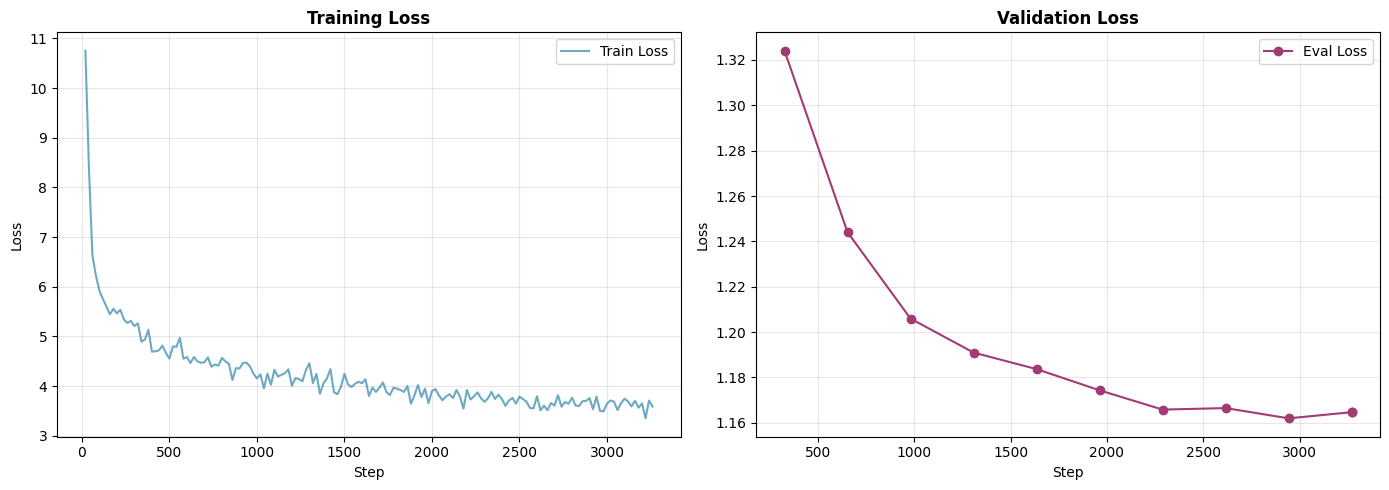

Saved: /content/drive/MyDrive/processed data/data/data/final_output/plots/training_curves.png


In [23]:
# ============================================================================
# PLOTTING - Training Curves
# ============================================================================
print(f"\n{'='*60}")
print("Generating plots")
print(f"{'='*60}")

# Extract training history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in mm_trainer.state.log_history:
    if "loss" in entry and "eval_loss" not in entry:
        train_steps.append(entry.get("step", len(train_steps)))
        train_losses.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry.get("step", len(eval_steps)))
        eval_losses.append(entry["eval_loss"])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_steps, train_losses, '-', color='#2E86AB', alpha=0.7, label='Train Loss')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

if eval_losses:
    axes[1].plot(eval_steps, eval_losses, 'o-', color='#A23B72', label='Eval Loss')
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Validation Loss', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plots", "training_curves.png"), dpi=150)
plt.show()
print(f"Saved: {OUTPUT_DIR}/plots/training_curves.png")


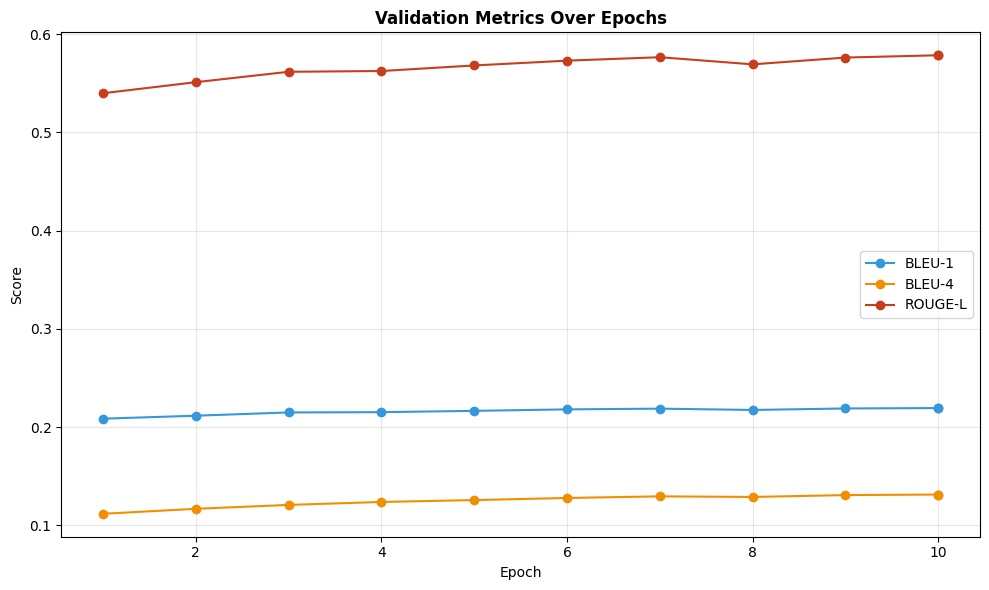

Saved: /content/drive/MyDrive/processed data/data/data/final_output/plots/metrics_per_epoch.png


In [24]:
# ============================================================================
# PLOTTING - Metrics over epochs
# ============================================================================
if len(metrics_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['epoch'], metrics_df['BLEU-1'], 'o-', label='BLEU-1', color='#3498db')
    plt.plot(metrics_df['epoch'], metrics_df['BLEU-4'], 'o-', label='BLEU-4', color='#F18F01')
    plt.plot(metrics_df['epoch'], metrics_df['ROUGE-L'], 'o-', label='ROUGE-L', color='#C73E1D')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics Over Epochs', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plots", "metrics_per_epoch.png"), dpi=150)
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/plots/metrics_per_epoch.png")


/tmp/ipython-input-1438315189.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


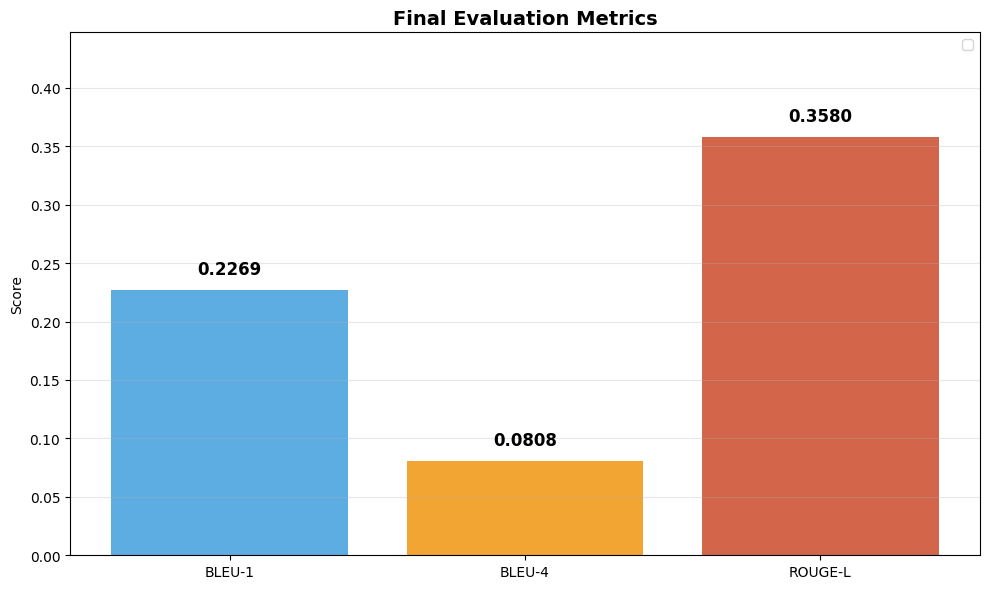

Saved: /content/drive/MyDrive/processed data/data/data/final_output/plots/final_metrics.png


In [7]:
# ============================================================================
# PLOTTING - Final metrics bar chart
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

metric_names = ['BLEU-1', 'BLEU-4', 'ROUGE-L']
metric_values = [final_metrics['BLEU-1'], final_metrics['BLEU-4'], final_metrics['ROUGE-L']]
colors = ['#3498db', '#F18F01', '#C73E1D']


bars = ax.bar(metric_names, metric_values, color=colors, alpha=0.8)

for bar, val in zip(bars, metric_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Score')
ax.set_title('Final Evaluation Metrics', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(metric_values) * 1.25)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plots", "final_metrics.png"), dpi=150)
plt.show()
print(f"Saved: {OUTPUT_DIR}/plots/final_metrics.png")


In [26]:
# ============================================================================
# TEST SET EVALUATION
# ============================================================================
print(f"\n{'='*60}")
print("Test set evaluation")
print(f"{'='*60}")

test_predictions = []
test_references = []
test_filenames = []

num_test = min(200, len(test_samples_mm))
print(f"Generating {num_test} test samples...")

for i in tqdm(range(num_test), desc="Test generation"):
    sample = test_samples_mm[i]
    gen_text = generate_conditioned(mm_model, tokenizer, sample, DEVICE, max_new_tokens=MAX_NEW_TOKENS)
    ref_text = sample.get("full_report", "") or sample.get("impression", "") or ""

    test_predictions.append(gen_text)
    test_references.append(ref_text)
    test_filenames.append(sample.get("filename", f"test_{i}"))

# Calculate test metrics
test_metrics = calculate_metrics(test_references, test_predictions)
print(f"\nTest Metrics:")
print(f"  BLEU-1:  {test_metrics['BLEU-1']:.4f}")
print(f"  BLEU-4:  {test_metrics['BLEU-4']:.4f}")
print(f"  ROUGE-L: {test_metrics['ROUGE-L']:.4f}")

# Save test predictions
test_pred_path = os.path.join(OUTPUT_DIR, "test_predictions.csv")
with open(test_pred_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["filename", "reference", "prediction"])
    for fn, r, p in zip(test_filenames, test_references, test_predictions):
        w.writerow([fn, r, p])
print(f"Saved test predictions to: {test_pred_path}")



Test set evaluation
Generating 200 test samples...


Test generation: 100%|██████████| 200/200 [04:50<00:00,  1.45s/it]



Test Metrics:
  BLEU-1:  0.2326
  BLEU-4:  0.0900
  ROUGE-L: 0.3787
Saved test predictions to: /content/drive/MyDrive/processed data/data/data/final_output/test_predictions.csv


In [27]:
# ============================================================================
# SAVE FINAL RESULTS
# ============================================================================
results = {
    "training_time_minutes": mm_train_time / 60,
    "eval_loss": eval_results.get("eval_loss"),
    "perplexity": mm_val_ppl,
    "validation_metrics": final_metrics,
    "test_metrics": test_metrics,
    "num_train_samples": len(mm_train_ds),
    "num_val_samples": len(mm_val_ds),
    "num_test_samples": len(mm_test_ds),
    "config": {
        "text_num_epochs": TEXT_NUM_EPOCHS,
        "mm_num_epochs": MM_NUM_EPOCHS,
        "mm_lr": MM_LR,
        "mm_batch_size": MM_TRAIN_BS,
        "mm_grad_accum": MM_GRAD_ACCUM,
        "cond_dim": COND_DIM,
    },
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

results_path = os.path.join(OUTPUT_DIR, "training_results.json")
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)
print(f"\nSaved results to: {results_path}")

# Save training log
log_path = os.path.join(OUTPUT_DIR, "training_log.json")
with open(log_path, "w") as f:
    json.dump(mm_trainer.state.log_history, f, indent=2)
print(f"Saved training log to: {log_path}")



Saved results to: /content/drive/MyDrive/processed data/data/data/final_output/training_results.json
Saved training log to: /content/drive/MyDrive/processed data/data/data/final_output/training_log.json


In [28]:
# ============================================================================
# SUMMARY
# ============================================================================
print(f"\n{'='*60}")
print("TRAINING COMPLETE!")
print(f"{'='*60}")

# Format perplexity string (handle None case)
ppl_str = f"{mm_val_ppl:.4f}" if mm_val_ppl else "N/A"

print(f"""
Summary:
  - Training time: {mm_train_time/60:.2f} minutes
  - Train samples: {len(mm_train_ds)}
  - Val samples: {len(mm_val_ds)}
  - Test samples: {len(mm_test_ds)}

Validation Metrics:
  - Perplexity: {ppl_str}
  - BLEU-1:  {final_metrics['BLEU-1']:.4f}
  - BLEU-4:  {final_metrics['BLEU-4']:.4f}
  - ROUGE-L: {final_metrics['ROUGE-L']:.4f}

Test Metrics:
  - BLEU-1:  {test_metrics['BLEU-1']:.4f}
  - BLEU-4:  {test_metrics['BLEU-4']:.4f}
  - ROUGE-L: {test_metrics['ROUGE-L']:.4f}

Output saved to: {OUTPUT_DIR}
  - full_multimodal_decoder/mm_model_state.pt
  - full_multimodal_decoder/tokenizer files
  - plots/
  - val_predictions.csv
  - test_predictions.csv
  - training_results.json
""")
print(f"{'='*60}")



TRAINING COMPLETE!

Summary:
  - Training time: 151.17 minutes
  - Train samples: 5223
  - Val samples: 1122
  - Test samples: 1121

Validation Metrics:
  - Perplexity: 3.2049
  - BLEU-1:  0.2269
  - BLEU-4:  0.0808
  - ROUGE-L: 0.3580

Test Metrics:
  - BLEU-1:  0.2326
  - BLEU-4:  0.0900
  - ROUGE-L: 0.3787

Output saved to: /content/drive/MyDrive/processed data/data/data/final_output
  - full_multimodal_decoder/mm_model_state.pt
  - full_multimodal_decoder/tokenizer files
  - plots/
  - val_predictions.csv
  - test_predictions.csv
  - training_results.json

